In [57]:
import pandas as pd
import json
import logging
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

In [72]:
def save_to_table_from_json(json_file, output_csv="articles_table.csv"):
    """Создаёт таблицу из JSON-файла и сохраняет в CSV."""
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df.index.name = "ID"
    df.to_csv(output_csv, index=True)
    logging.info(f"Данные сохранены в CSV-файл: {output_csv}")
    return df

df = save_to_table_from_json("combined_data.json", "entities_table.csv")

In [73]:
df['title'].value_counts()

title
Willis Conover                       2
Fritz Leiber                         2
Donald Wandrei                       2
Virgil Finlay                        2
August Derleth                       2
                                    ..
Works inspired by H. P. Lovecraft    1
H. P. Lovecraft                      1
H.P.L.: A Reminiscence               1
H'chtelegoth Press                   1
Esther Whipple                       1
Name: count, Length: 5560, dtype: int64

In [74]:
df['class'].value_counts()

class
Work               3080
Character          1304
RealWorldPerson     740
Location            282
Artefact             99
Organisation         61
Name: count, dtype: int64

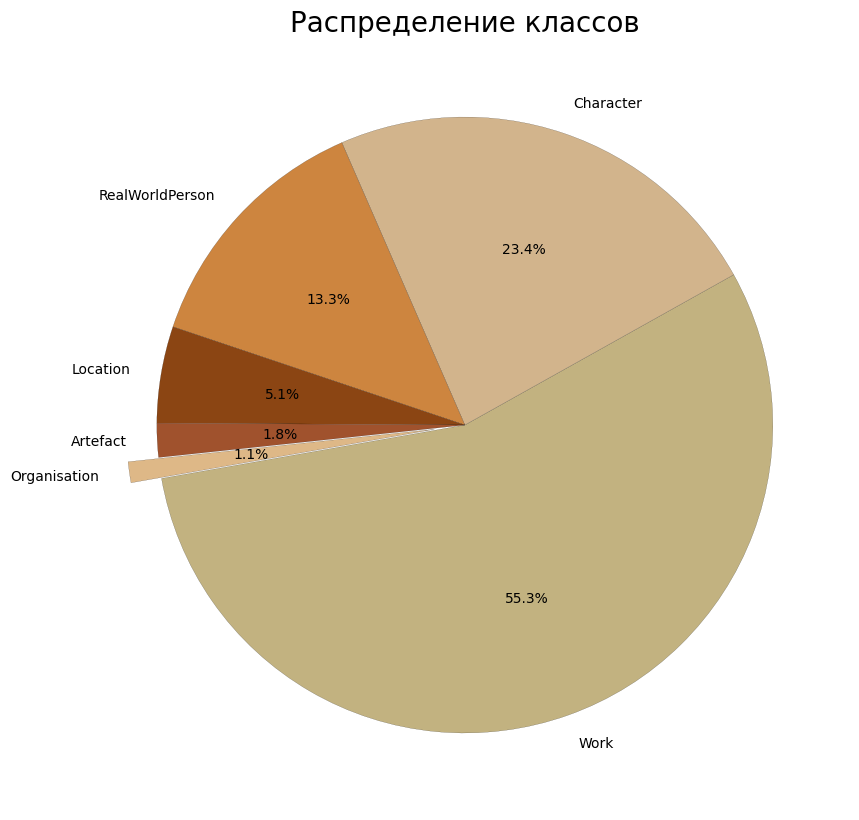

In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Подсчет количества значений в каждом классе
class_counts = df['class'].value_counts()

# Увеличение минимального сегмента
explode = np.where(class_counts == class_counts.min(), 0.1, 0)

# Цветовая палитра
colors = ['#C2B280', '#D2B48C', '#CD853F', '#8B4513', '#A0522D', '#DEB887']

# Построение круговой диаграммы
plt.figure(figsize=(15, 10))
class_counts.plot(
    kind='pie',
    autopct=lambda p: f'{p:.1f}%' if p > 1 else '',  # Проценты отображаем только для значений > 1%
    startangle=190,
    legend=False,
    colors=colors,
    explode=explode,
    wedgeprops={'edgecolor': 'black', 'linewidth': 0.1}
)

# Настройка заголовка и осей
plt.title('Распределение классов', fontsize=20)
plt.ylabel('')  # Убираем подпись оси Y
plt.show()


**Распределение классов и подклассов**


Цель: Понять, какие подклассы чаще всего встречаются в каждом классе.

In [76]:
df.groupby('class')['subclass'].apply(lambda x: x.explode().value_counts())  # По классам

class                                                
Artefact  MythosLiterature                               85
          MythosBooksFictional                           53
          MysticalArtefacts                              26
          TechnologicalArtefacts                         15
          ArtefactsOriginatingFromMythosAdjacentWorks     9
                                                         ..
Work      PennyFrierson                                   1
          SpectraFiles                                    1
          Ezines                                          1
          TheSalemHawleySeries                            1
          ZothiqueStoryCycle                              1
Name: subclass, Length: 145, dtype: int64

/var/folders/tz/03m96h9d79gb8ybshv14drgw0000gn/T/ipykernel_43422/106710059.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_counts = grouped_counts.groupby('class', group_keys=False).apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)


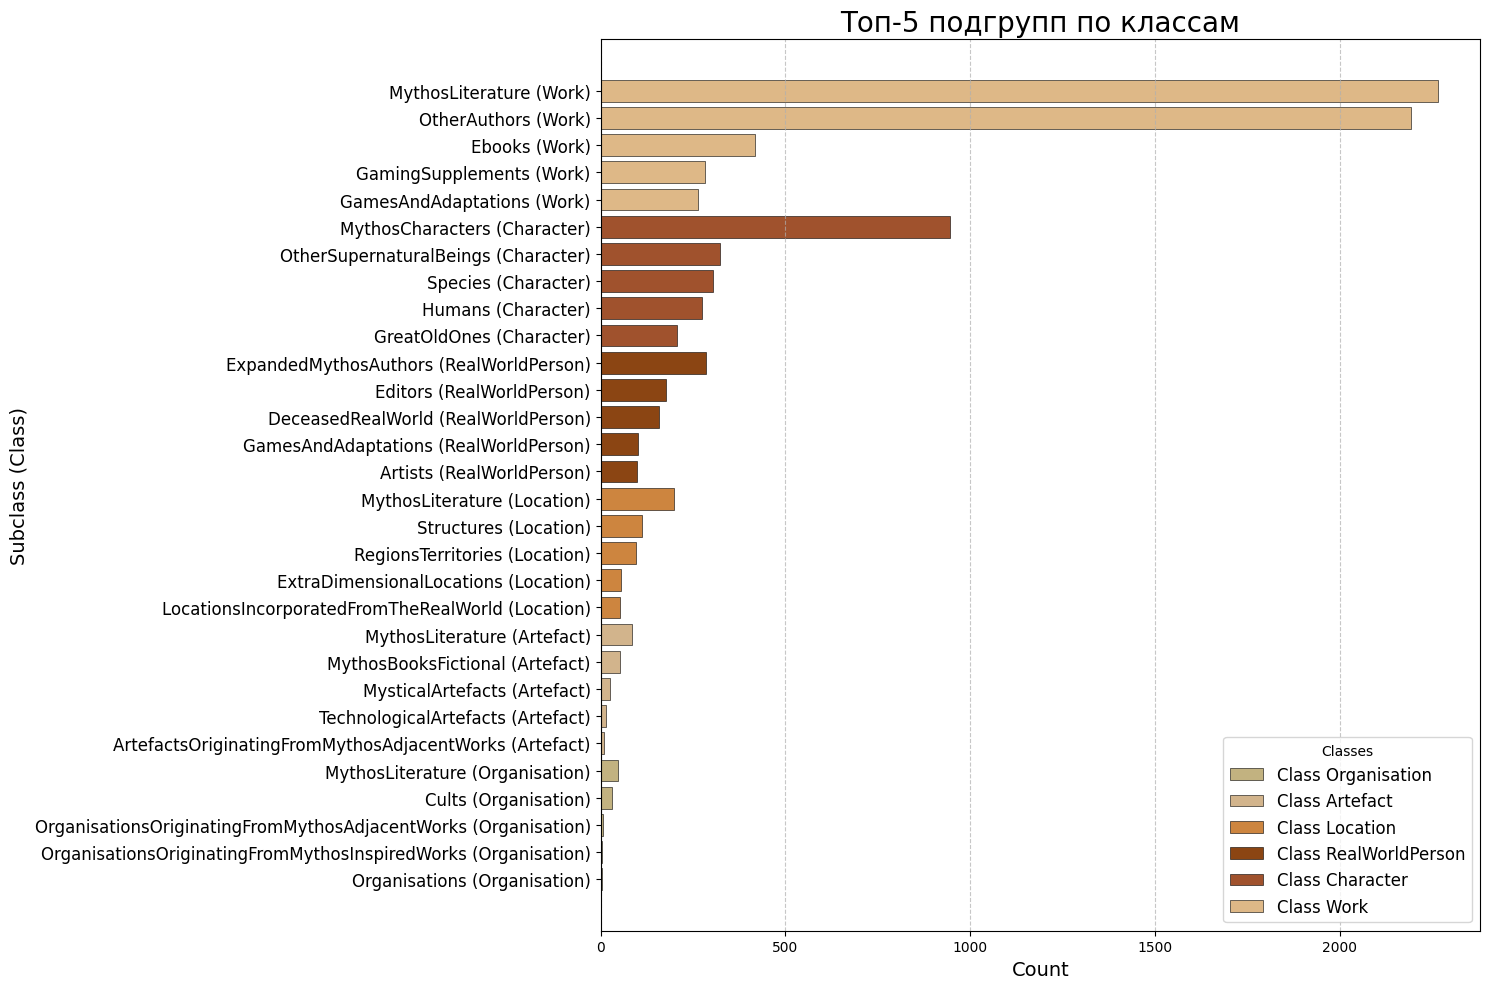

In [77]:
import matplotlib.pyplot as plt

# Оставляем только топ-5 подгрупп для каждого класса
top_5_counts = grouped_counts.groupby('class', group_keys=False).apply(lambda x: x.nlargest(5, 'count')).reset_index(drop=True)

# Упорядочиваем данные
top_5_counts['combined_label'] = top_5_counts['subclass'] + " (" + top_5_counts['class'] + ")"
top_5_counts = top_5_counts.sort_values(by='count', ascending=True)

# Обновленная цветовая палитра
colors = ['#C2B280', '#D2B48C', '#CD853F', '#8B4513', '#A0522D', '#DEB887']

plt.figure(figsize=(15, 10))

for i, cls in enumerate(top_5_counts['class'].unique()):
    subset = top_5_counts[top_5_counts['class'] == cls]
    plt.barh(
        subset['combined_label'],
        subset['count'],
        color=colors[i % len(colors)],
        label=f'Class {cls}',
        edgecolor='black',  
        linewidth=0.4,        
    )

# Настройка визуализации
plt.title('Топ-5 подгрупп по классам', fontsize=20)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Subclass (Class)', fontsize=14)
plt.yticks(fontsize=12)
plt.legend(title='Classes', fontsize=12, loc='lower right')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Показ графика
plt.tight_layout()
plt.show()


**Анализ атрибутов из infobox**

Цель: Понять, какие ключи (атрибуты) наиболее часто встречаются в infobox по классам. Найти процент встречаемости атрибута в пределах каждого класса для анализа и подготовки атрибутов в качестве properties для графа.

In [78]:
# Функция для извлечения ключей infobox с привязкой к классам
def get_infobox_keys_with_classes(row):
    if isinstance(row['infobox'], dict):
        return [(row['class'], key) for key in row['infobox'].keys()]
    return []

# Извлекаем ключи infobox с их классами
infobox_keys_with_classes = df.apply(get_infobox_keys_with_classes, axis=1).explode()

# Фильтруем строки с NaN в ключах или классах
infobox_keys_with_classes = infobox_keys_with_classes.dropna()

# Считаем частоту ключей для каждого класса
classwise_key_counts = Counter(infobox_keys_with_classes)

# Преобразуем в DataFrame
result = pd.DataFrame(classwise_key_counts.items(), columns=['Class_Key', 'Count'])
result[['Class', 'Key']] = pd.DataFrame(result['Class_Key'].tolist(), index=result.index)
result.drop(columns='Class_Key', inplace=True)

# Добавляем процентную колонку
total_entities_per_class = df['class'].value_counts()
result['Percentage'] = result.apply(
    lambda row: round((row['Count'] / total_entities_per_class[row['Class']]) * 100, 2), axis=1
)

# Сортируем результат
result_sorted = result.sort_values(by=['Class', 'Count'], ascending=[True, False])
result_sorted.reset_index(drop=True, inplace=True)

# Группируем и отображаем топ-10 для каждого класса
for class_name in result_sorted['Class'].unique():
    top12 = result_sorted[result_sorted['Class'] == class_name].head(12)
    print(f"Top 12 keys for class '{class_name}':")
    display(top12)

Top 12 keys for class 'Artefact':


,Count,Class,Key,Percentage
0,66,Artefact,first_appearance,66.67
1,54,Artefact,created_by,54.55
2,39,Artefact,type,39.39
3,36,Artefact,creator,36.36
4,26,Artefact,function,26.26
5,23,Artefact,author,23.23
6,21,Artefact,used_by,21.21
7,19,Artefact,place_of_origin,19.19
8,18,Artefact,also_known_as,18.18
9,17,Artefact,language,17.17


Top 12 keys for class 'Character':


,Count,Class,Key,Percentage
24,1120,Character,first_appearance,85.89
25,1071,Character,created_by,82.13
26,516,Character,also_known_as,39.57
27,502,Character,affiliations,38.50
28,451,Character,species,34.59
29,436,Character,origin,33.44
30,353,Character,occupation,27.07
31,290,Character,appearances,22.24
32,194,Character,powers_and_abilities,14.88
33,139,Character,hasRelative,10.66


Top 12 keys for class 'Location':


,Count,Class,Key,Percentage
77,210,Location,location,74.47
78,210,Location,type,74.47
79,198,Location,created_by,70.21
80,195,Location,first_appearance,69.15
81,129,Location,inhabitants,45.74
82,79,Location,appearances,28.01
83,53,Location,notable_features,18.79
84,50,Location,accessibility,17.73
85,36,Location,ruling_powers,12.77
86,30,Location,also_known_as,10.64


Top 12 keys for class 'Organisation':


,Count,Class,Key,Percentage
98,35,Organisation,first_appearance,57.38
99,33,Organisation,type,54.10
100,31,Organisation,created_by,50.82
101,24,Organisation,affiliations,39.34
102,22,Organisation,location,36.07
103,22,Organisation,notable_members,36.07
104,21,Organisation,appearances,34.43
105,20,Organisation,purpose,32.79
106,6,Organisation,also_known_as,9.84


Top 12 keys for class 'RealWorldPerson':


,Count,Class,Key,Percentage
107,469,RealWorldPerson,connection_to_the_mythos,63.38
108,428,RealWorldPerson,birth_date,57.84
109,407,RealWorldPerson,nationality,55.00
110,317,RealWorldPerson,birthplace,42.84
111,281,RealWorldPerson,genre,37.97
112,281,RealWorldPerson,death_date,37.97
113,215,RealWorldPerson,website,29.05
114,158,RealWorldPerson,full_name,21.35
115,85,RealWorldPerson,deathplace,11.49
116,80,RealWorldPerson,pseudonym(s),10.81


Top 12 keys for class 'Work':


,Count,Class,Key,Percentage
146,2833,Work,language,91.98
147,2676,Work,author,86.88
148,2106,Work,publisher,68.38
149,1421,Work,publication_date,46.14
150,1335,Work,genre(s),43.34
151,1258,Work,country,40.84
152,1258,Work,release_date,40.84
153,1173,Work,publication,38.08
154,829,Work,pages,26.92
155,630,Work,series,20.45


In [79]:
# Функция для извлечения ключей infobox с привязкой к классам
def get_infobox_keys_with_classes(row):
    if isinstance(row['infobox'], dict):
        return [(row['class'], key) for key in row['infobox'].keys()]
    return []

# Извлекаем ключи infobox с их классами
infobox_keys_with_classes = df.apply(get_infobox_keys_with_classes, axis=1).explode()

# Фильтруем строки с NaN в ключах или классах
infobox_keys_with_classes = infobox_keys_with_classes.dropna()

# Считаем частоту ключей для каждого класса
classwise_key_counts = Counter(infobox_keys_with_classes)

# Преобразуем в DataFrame
result = pd.DataFrame(classwise_key_counts.items(), columns=['Class_Key', 'Count'])
result[['Class', 'Key']] = pd.DataFrame(result['Class_Key'].tolist(), index=result.index)
result.drop(columns='Class_Key', inplace=True)

# Добавляем процентную колонку
total_entities_per_class = df['class'].value_counts()
result['Percentage'] = result.apply(
    lambda row: round((row['Count'] / total_entities_per_class[row['Class']]) * 100, 2), axis=1
)

# Фильтруем только для классов Character и RealWorldPerson
filtered_result = result[result['Class'].isin(['Character', 'RealWorldPerson'])]

# Сортируем результат
filtered_result_sorted = filtered_result.sort_values(by=['Class', 'Count'], ascending=[True, False])
filtered_result_sorted.reset_index(drop=True, inplace=True)

# Группируем и отображаем все атрибуты для каждого класса
for class_name in filtered_result_sorted['Class'].unique():
    class_attributes = filtered_result_sorted[filtered_result_sorted['Class'] == class_name]
    print(f"All attributes for class '{class_name}':")
    display(class_attributes)

All attributes for class 'Character':


,Count,Class,Key,Percentage
0,1120,Character,first_appearance,85.89
1,1071,Character,created_by,82.13
2,516,Character,also_known_as,39.57
3,502,Character,affiliations,38.50
4,451,Character,species,34.59
5,436,Character,origin,33.44
6,353,Character,occupation,27.07
7,290,Character,appearances,22.24
8,194,Character,powers_and_abilities,14.88
9,139,Character,hasRelative,10.66


All attributes for class 'RealWorldPerson':


,Count,Class,Key,Percentage
53,469,RealWorldPerson,connection_to_the_mythos,63.38
54,428,RealWorldPerson,birth_date,57.84
55,407,RealWorldPerson,nationality,55.00
56,317,RealWorldPerson,birthplace,42.84
57,281,RealWorldPerson,genre,37.97
58,281,RealWorldPerson,death_date,37.97
59,215,RealWorldPerson,website,29.05
60,158,RealWorldPerson,full_name,21.35
61,85,RealWorldPerson,deathplace,11.49
62,80,RealWorldPerson,pseudonym(s),10.81


In [80]:
# Функция для извлечения всех ключей инфобоксов с учётом вложенности
def extract_nested_keys(data, prefix=''):
    """
    Рекурсивно извлекает ключи из вложенных словарей.
    """
    keys = []
    if isinstance(data, dict):
        for k, v in data.items():
            new_prefix = f"{prefix}.{k}" if prefix else k
            keys.append(new_prefix)
            keys.extend(extract_nested_keys(v, new_prefix))
    elif isinstance(data, list):
        for i, item in enumerate(data):
            new_prefix = f"{prefix}[{i}]"
            keys.extend(extract_nested_keys(item, new_prefix))
    return keys

# Функция для извлечения ключей инфобокса с привязкой к классам
def get_infobox_keys_with_classes(row):
    if isinstance(row['infobox'], dict):
        nested_keys = extract_nested_keys(row['infobox'])
        return [(row['class'], key) for key in nested_keys]
    return []

# Извлекаем ключи инфобоксов с их классами
infobox_keys_with_classes = df.apply(get_infobox_keys_with_classes, axis=1).explode()

# Фильтруем строки с NaN в ключах или классах
infobox_keys_with_classes = infobox_keys_with_classes.dropna()

# Считаем частоту ключей для каждого класса
classwise_key_counts = Counter(infobox_keys_with_classes)

# Преобразуем в DataFrame
result = pd.DataFrame(classwise_key_counts.items(), columns=['Class_Key', 'Count'])
result[['Class', 'Key']] = pd.DataFrame(result['Class_Key'].tolist(), index=result.index)
result.drop(columns='Class_Key', inplace=True)

# Добавляем процентную колонку
total_entities_per_class = df['class'].value_counts()
result['Percentage'] = result.apply(
    lambda row: round((row['Count'] / total_entities_per_class[row['Class']]) * 100, 2), axis=1
)

# Сортируем результат
result_sorted = result.sort_values(by=['Class', 'Count'], ascending=[True, False])
result_sorted.reset_index(drop=True, inplace=True)

# Фильтруем по классам Character и RealWorldPerson и выводим
filtered_result = result_sorted[result_sorted['Class'].isin(['Character', 'RealWorldPerson'])]

for class_name in filtered_result['Class'].unique():
    class_attributes = filtered_result[filtered_result['Class'] == class_name]
    print(f"All attributes for class '{class_name}':")
    display(class_attributes)

All attributes for class 'Character':


,Count,Class,Key,Percentage
24,1120,Character,first_appearance,85.89
25,1071,Character,created_by,82.13
26,516,Character,also_known_as,39.57
27,502,Character,affiliations,38.50
28,451,Character,species,34.59
29,436,Character,origin,33.44
30,353,Character,occupation,27.07
31,290,Character,appearances,22.24
32,194,Character,powers_and_abilities,14.88
33,139,Character,hasRelative,10.66


All attributes for class 'RealWorldPerson':


,Count,Class,Key,Percentage
107,469,RealWorldPerson,connection_to_the_mythos,63.38
108,428,RealWorldPerson,birth_date,57.84
109,407,RealWorldPerson,nationality,55.00
110,317,RealWorldPerson,birthplace,42.84
111,281,RealWorldPerson,genre,37.97
112,281,RealWorldPerson,death_date,37.97
113,215,RealWorldPerson,website,29.05
114,158,RealWorldPerson,full_name,21.35
115,85,RealWorldPerson,deathplace,11.49
116,80,RealWorldPerson,pseudonym(s),10.81


**Сравнение классов по количеству подгрупп**


Цель: Проверить, в каких записях отсутствуют важные данные, такие как infobox или content.

In [81]:
df[df['infobox'].isnull() | df['content'].isnull()]  # Записи с пропущенными данными

,title,class,subclass,content,infobox
ID,,,,,


**Поиск записей с пропущенными данными**


Цель: Показать, какие классы имеют наиболее разнообразные подгруппы.

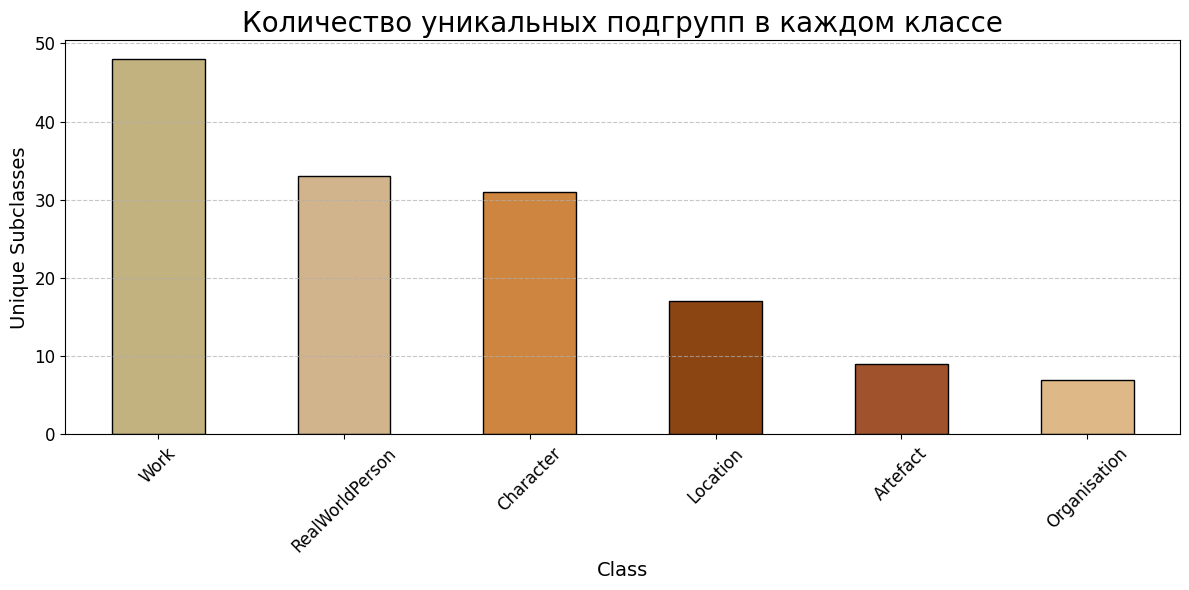

In [67]:
# Разворачиваем списки в 'subclass'
df_exploded = df.explode('subclass')

# Подсчет уникальных подгрупп по каждому классу
unique_subclass_counts = df_exploded.groupby('class')['subclass'].nunique()

# Цвета для каждого класса
colors = ['#C2B280', '#D2B48C', '#CD853F', '#8B4513', '#A0522D', '#DEB887']

# Построение гистограммы
plt.figure(figsize=(12, 6))
unique_subclass_counts.sort_values(ascending=False).plot(
    kind='bar', 
    color=colors[:len(unique_subclass_counts)],  # Используем цвета для каждого класса
    edgecolor='black'
)

# Настройка визуализации
plt.title("Количество уникальных подгрупп в каждом классе", fontsize=20)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Unique Subclasses", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показываем график
plt.tight_layout()
plt.show()


**Связи между классами (графовая визуализация)**

Цель: Построить граф, отображающий связи между различными классами через свойства инфобоксов.

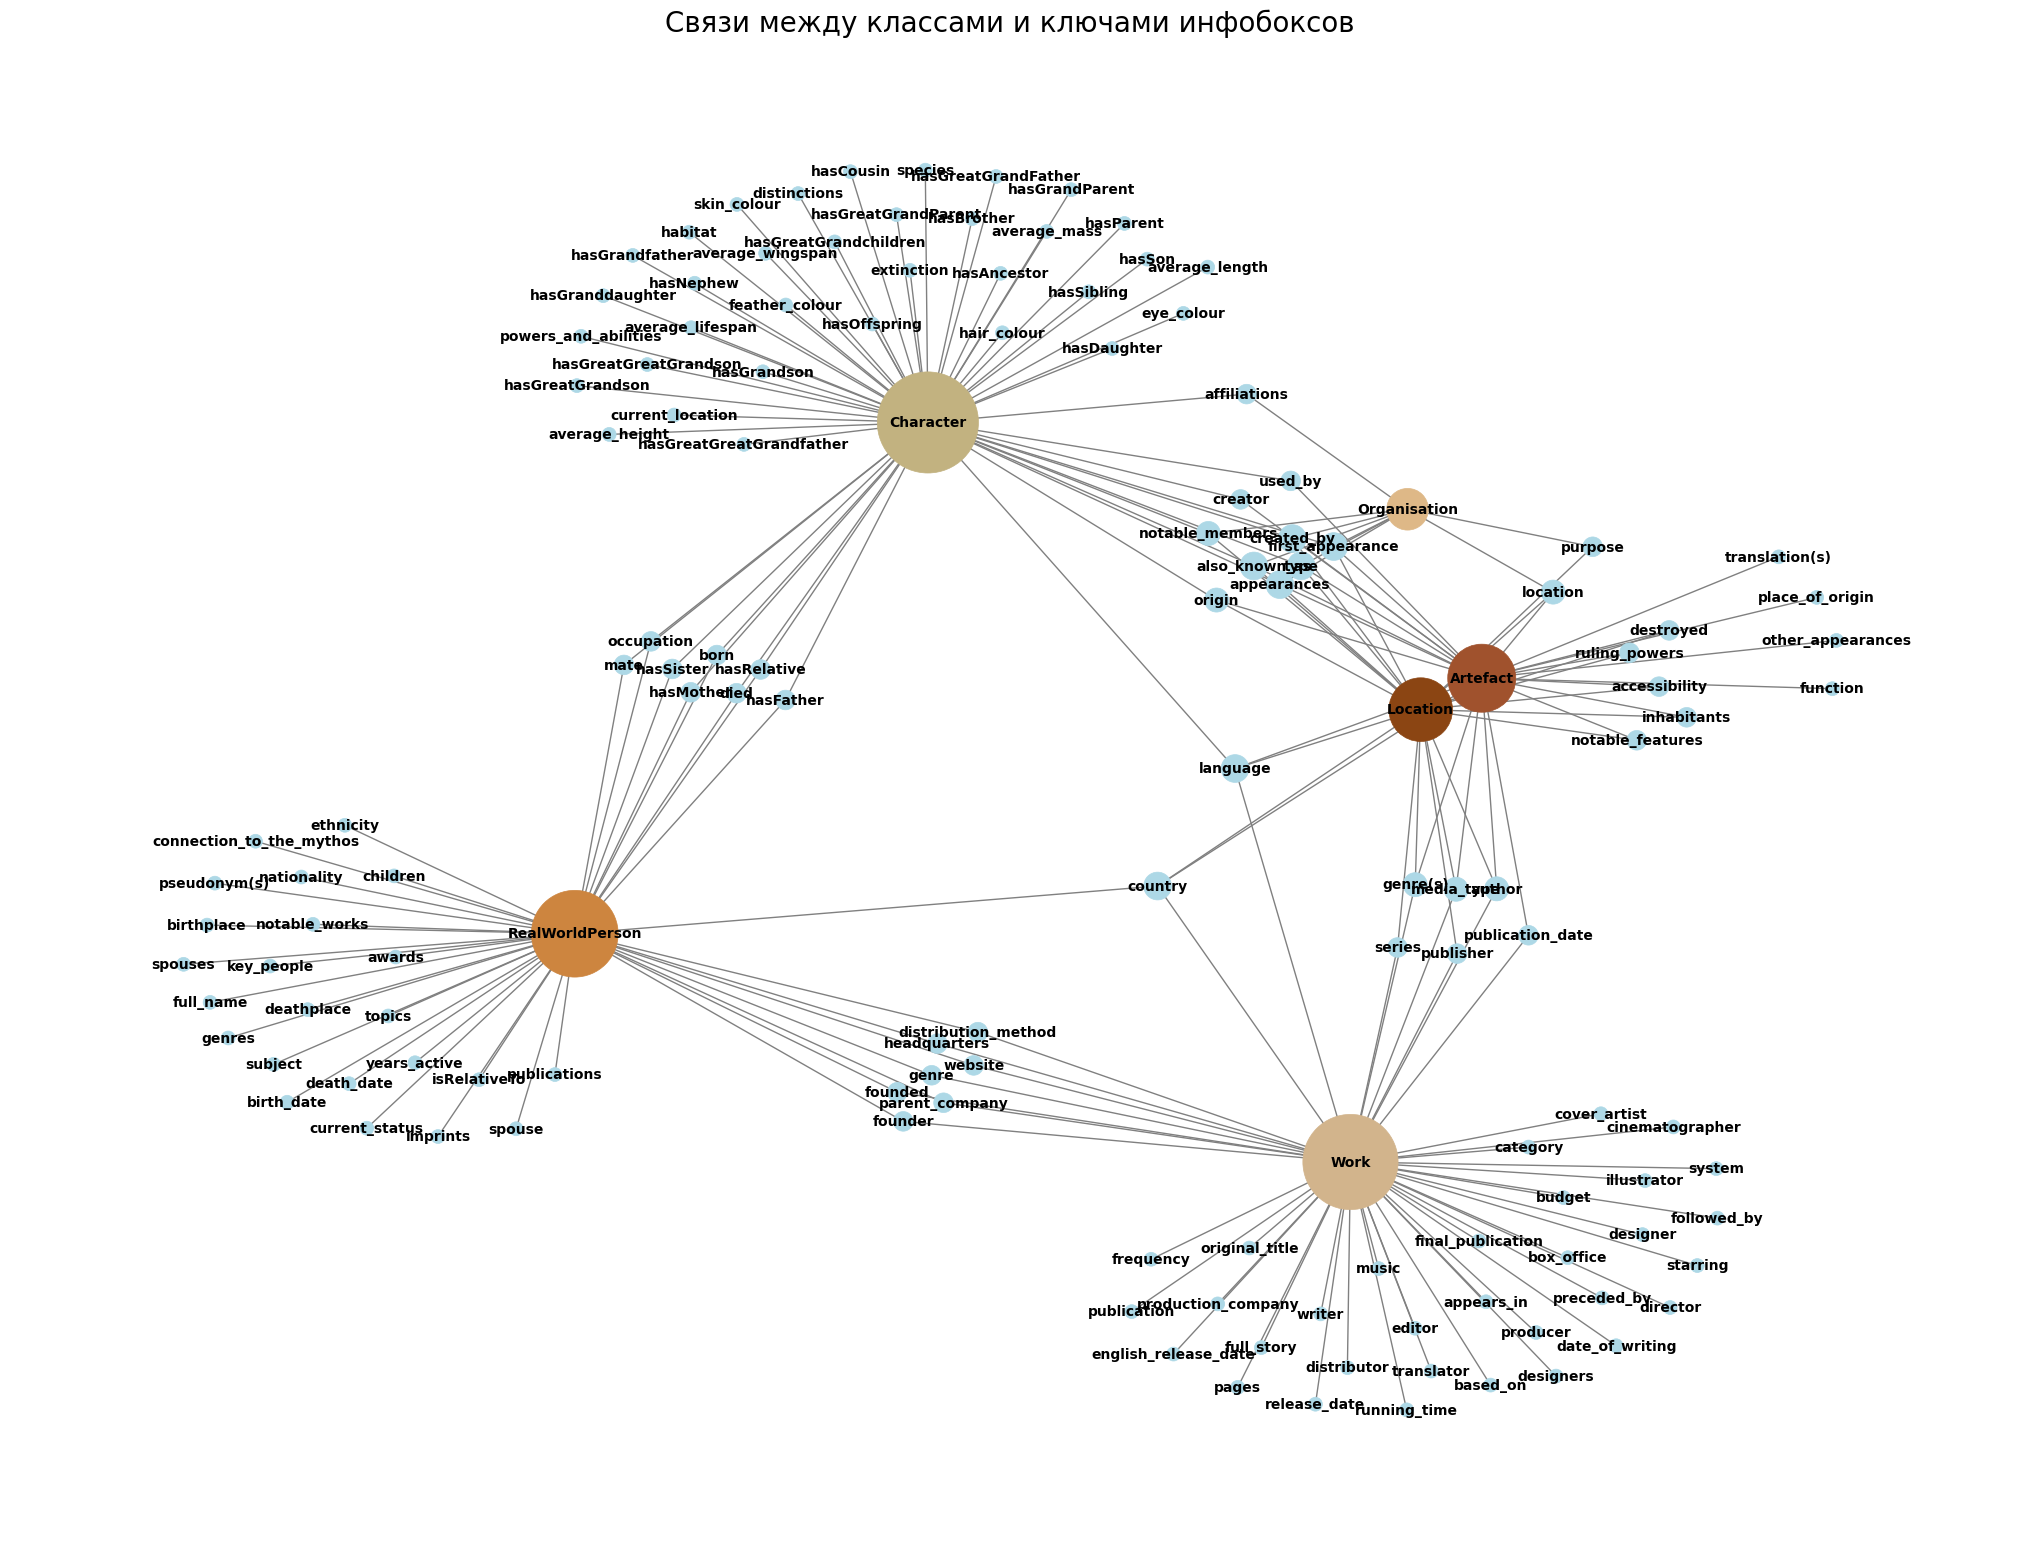

In [82]:
colors = ['#C2B280', '#D2B48C', '#CD853F', '#8B4513', '#A0522D', '#DEB887']

# Сопоставляем цвета классам
class_color_map = {cls: colors[i % len(colors)] for i, cls in enumerate(df['class'].unique())}

# Функция для извлечения ключей инфобокса с привязкой к классам
def get_infobox_keys_with_classes(row):
    if isinstance(row['infobox'], dict):
        return [(row['class'], key) for key in row['infobox'].keys()]
    return []

# Извлекаем ключи инфобокса с их классами
infobox_keys_with_classes = df.apply(get_infobox_keys_with_classes, axis=1).explode()

# Убираем NaN значения, если есть
infobox_keys_with_classes = infobox_keys_with_classes.dropna()

# Считаем частоты ключей по классам
classwise_key_counts = Counter(infobox_keys_with_classes)

# Преобразуем в DataFrame
result = pd.DataFrame(classwise_key_counts.items(), columns=['Class_Key', 'Count'])
result[['Class', 'Key']] = pd.DataFrame(result['Class_Key'].tolist(), index=result.index)
result.drop(columns='Class_Key', inplace=True)

# Строим граф
G = nx.Graph()
edges = [(row['Class'], row['Key']) for _, row in result.iterrows()]
G.add_edges_from(edges)

# Настройка цвета и размера узлов
node_colors = []
for node in G.nodes():
    if node in result['Class'].values:
        node_colors.append(class_color_map[node])  # Цвет для классов
    else:
        node_colors.append('#ADD8E6')  # Светло-голубой для ключей

# Размер узлов в зависимости от степени
node_sizes = [G.degree(node) * 100 for node in G.nodes()]

# Визуализация графа
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G, seed=42)  # Расположение узлов
nx.draw(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    font_size=10,
    edge_color='gray',
    font_weight='bold',
    linewidths=0.5
)

plt.title('Связи между классами и ключами инфобоксов', fontsize=20)
plt.show()